# Plotting Figure S3

This script is used to plot Figure S3 rmse

ref: https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0  

In [1]:
import xarray as xr
import datetime
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import time
import gc
import util
import seaborn as sns
from s3fs.core import S3FileSystem

In [2]:
def draw_screen_poly(lats, lons, map):
    x, y = map( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), 
                   edgecolor="black",
                   facecolor="None",
                   lw=1.5)
    plt.gca().add_patch(poly)

def global_map_plot(df, ax, variable, vmin, vmax, cmap, 
                    cbar_extend="both",
                    lon_labels=[True,False,False,True],
                    lat_labels=[True,False,False,True],
                    reset_lon=False):
    
    if reset_lon!=False:
        # get new coordinate
        df["lon_new"] = np.where(df['lon'] <= 180, df['lon'], df['lon']-360)
    else:
        df["lon_new"] = df["lon"]
    
    # Midwest US
    # https://en.wikipedia.org/wiki/Module:Location_map/data/USA_Midwest
    lats_mw_us = [ 36.15, 49.5, 49.5, 36.15 ]
    lons_mw_us = [ -95, -95, -75, -75 ]

    # Europe
    lats_eu = [ 40, 50, 50, 40 ]
    lons_eu = [ 15, 15, 30, 30 ]

    # India https://link.springer.com/article/10.1007/s12524-011-0119-x
    # Just say central India and the indo gangetic plains 
    lats_in = [ 18, 25, 25, 18 ]
    lons_in = [ 75, 75, 87, 87 ]

    # https://baike.baidu.com/item/%E5%8D%8E%E5%8C%97%E5%B9%B3%E5%8E%9F
    lats_ch = [ 32, 45, 45, 32 ]
    lons_ch = [ 110, 110, 123, 123 ]    
    
    map = Basemap(ax=ax)
    map.drawcoastlines()
    map.readshapefile('./shapefile/maps', 'maps')
    #map.drawstates()
    #map.drawcountries()
    map.drawmeridians(range(-180, 180, 60),labels=lon_labels,fontsize=12)
    map.drawparallels(range(-60, 70, 30), labels=lat_labels,fontsize=12)
    draw_screen_poly(lats_mw_us, lons_mw_us, map)
    draw_screen_poly(lats_eu, lons_eu, map)
    draw_screen_poly(lats_in, lons_in, map)
    draw_screen_poly(lats_ch, lons_ch, map)
    
    if cmap == "bwr":
        map.fillcontinents(zorder=0)
    p = ax.scatter(df["lon_new"], df["lat"], 
                c=df[variable],
                s=0.5, cmap=cmap, vmin=vmin, vmax=vmax,rasterized=True)
    
    clb = plt.colorbar(p, ax=ax, orientation="vertical",
                       fraction=0.1,
                       shrink=0.75,
                       pad=0.02,
                       aspect=30,
                       extend=cbar_extend)
    clb.ax.tick_params(labelsize=12)

## load rmse

In [3]:
s3 = S3FileSystem()
validation_path = "/data/keeling/a/zzheng25/b/UrbanHWs/CESM_validation/"
save_dir = "S3://uhws/UHWs_CESM/model-validation-diff/"
df = pd.read_csv(save_dir+"rmse_by_lat_lon.csv")
df_mean = df.set_index(["lat","lon"]).mean(axis=1)
df_mean.describe()

count    4439.000000
mean        0.000846
std         0.009589
min        -0.040876
25%        -0.005092
50%         0.000423
75%         0.006312
max         0.052918
dtype: float64

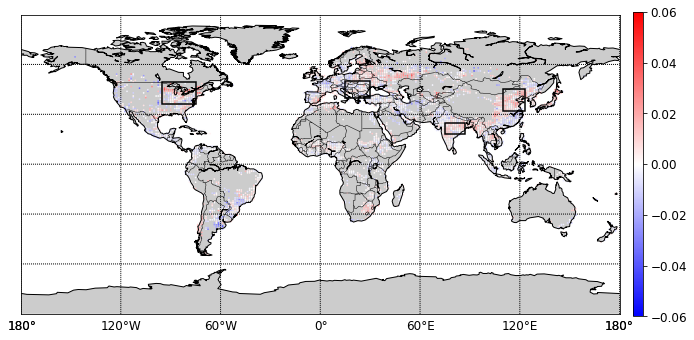

In [4]:
rc={'axes.labelsize': 12, 'font.size': 12, 'legend.fontsize': 12, 'axes.titlesize': 12}
plt.rcParams.update(**rc)

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
# ax.set_title("(b)")
global_map_plot(df_mean.reset_index(), 
                ax,
                0, -0.06, 0.06, "bwr", "neither",
                lat_labels=[False,False,False,False],
                reset_lon=True)
plt.tight_layout()
plt.savefig("../figures/warming.pdf",dpi=288)
plt.show()